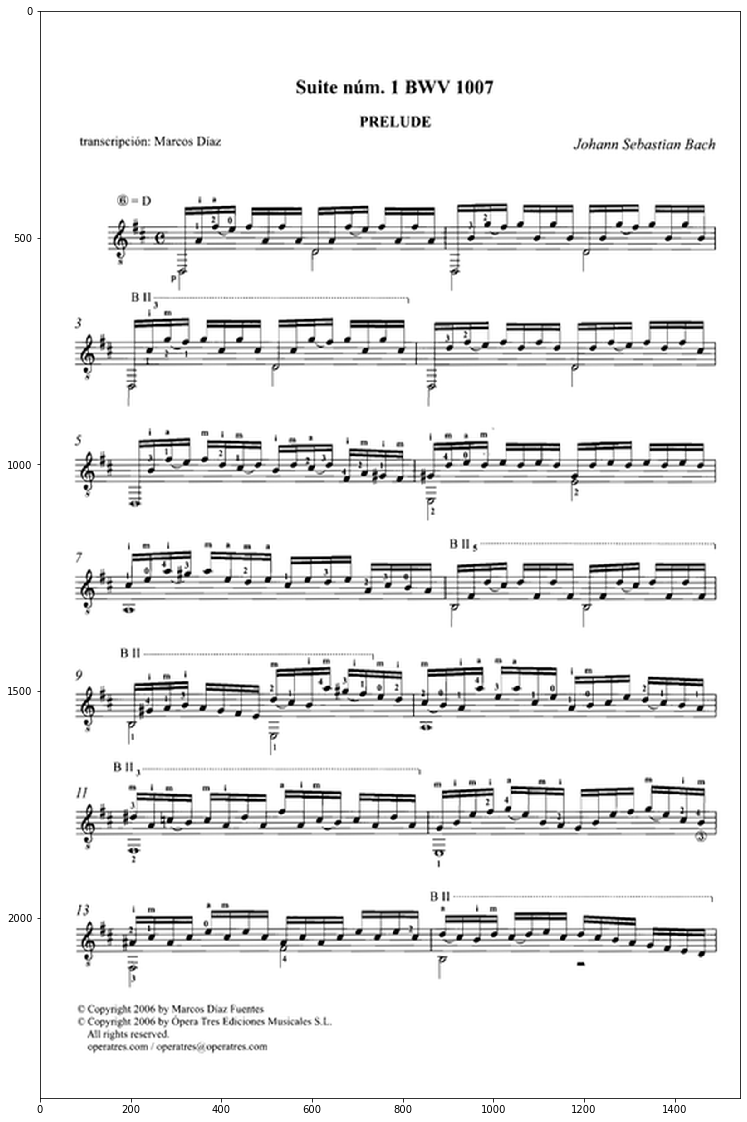

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageEnhance, ImageOps
import random
import os
from tqdm import tqdm

im = Image.open("data/clean/music/6_cello_suites_arr_Marcos_Diaz_-_J_S_Bach-02.png").convert('RGB')
# print(im.size)
im = im.resize((500,705), resample=Image.LANCZOS)
im = im.resize((1545, 2398), resample=Image.LANCZOS)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(im, interpolation='nearest')


In [3]:
# tst = blend(im)
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(tst, interpolation='nearest')

In [4]:
def blemish(img):
    img_in = img.copy()
    img_arr = np.asarray(img_in)
    points = random.choice(list(range(50, 130)))
    
    sizes = list(range(1,6))
    coords = [(random.choice(range(img_arr.shape[1]-2*max(sizes))), random.choice(range(img_arr.shape[0]-2*max(sizes)))) for _ in range(points)]
    
    draw = ImageDraw.Draw(img_in) 
    for x, y in coords:
        size = random.choice(sizes)
        draw.ellipse([x-size, y-size, x+size, y+size], fill=0, outline=0,width=1)
    
    return img_in

def noise(img, factor=0.1):
    img_arr = np.asarray(img)
    noise = np.random.rand(*img_arr.shape)
    noise = img_arr * noise * factor
    img_arr = img_arr - noise
    img_out = Image.fromarray(np.uint8(img_arr.clip(min=0)))
    return img_out

def grey_patching(img, by=20):
    img_arr = np.asarray(img).copy()
    random_reduction = np.random.randint(by, size=img_arr.shape[:2])
    random_reduction = np.dstack((random_reduction,random_reduction,random_reduction))
    img_arr = img_arr - random_reduction           
    img_out = Image.fromarray(np.uint8(img_arr.clip(min=0)))
    return img_out

def blend(img, dirty_masks='data/damage_examples'):
    mask = random.choice(os.listdir(dirty_masks))
    mask_img = Image.open(dirty_masks+"/"+mask).convert('RGB')
    mask_img = mask_img.resize(img.size)
    rand = random.random() 
    if rand < 0.5:
        mask_img = mask_img.rotate(180)
        
    rand = random.random() 
    if rand < 0.5:
        mask_img = mask_img.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        mask_img = mask_img.transpose(Image.FLIP_TOP_BOTTOM)
    
    
    mask_arr = np.asarray(mask_img, dtype=np.float32)
    img_arr = np.asarray(img, dtype=np.float32)
    
#     if random.random() < 0.75:
#         comb = (img_arr+mask_arr*0.7)/2
#     else:
    comb = (img_arr+mask_arr)/2
        
    img_out = Image.fromarray(np.uint8(comb.clip(min=0, max=255)))
    img_out = ImageEnhance.Contrast(img_out).enhance(2)
#     img_out = ImageEnhance.Brightness(img_out).enhance(1)
    return img_out



modifications = [[blend, blemish],
                 [blend, blemish],
                 [blend, noise],
                 [blend, grey_patching],
                 [blemish],
                 [blend],
                 [blend]]

In [5]:
clean_dir = 'data/clean/music/'
damaged_dir = 'data/damaged/music/'
for file in tqdm(os.listdir(clean_dir)):

    dots = random.choice(list(range(40, 120)))
    greying = random.choice(list(range(1, 30)))
    
    img = Image.open(clean_dir+file).convert('RGB')
    mods = random.choice(modifications)
    damage = img.copy()
    for mod in mods:
        damage = mod(damage)
    
    damage.save(damaged_dir+file+"_dmg.png", "PNG")

100%|██████████████████████████████████████████████████████████████████████████████| 1348/1348 [18:51<00:00,  1.19it/s]


In [29]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageEnhance, ImageOps
import random
import os

from tqdm import tqdm

In [30]:
batch_size = 8

cln_trnsfrm = transforms.Compose([transforms.Resize((988, 700), interpolation=1),
                                  transforms.Grayscale(num_output_channels=1),
                                  transforms.ToTensor()]
                                )

clean_data_fldr = datasets.ImageFolder('data\clean', transform=cln_trnsfrm)
clean_data = torch.utils.data.DataLoader(clean_data_fldr,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4)


dmg_trnsfrm = transforms.Compose([transforms.Resize((987, 700), interpolation=1),
                                  transforms.ToTensor(),
                                  transforms.Grayscale(num_output_channels=1)]
                                )

damaged_data_fldr = datasets.ImageFolder('data\damaged', transform=dmg_trnsfrm)  
damaged_data = torch.utils.data.DataLoader(damaged_data_fldr,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4)

In [31]:
# class CNNAutoEncoder(nn.Module):
#     def __init__(self):
#         super(CNNAutoEncoder, self).__init__()

#         self.conv1_1 = nn.Conv2d(1, 32, 3, padding=1)  
#         self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)

#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2_1 = nn.Conv2d(32, 32, 3, padding=1, stride=2)  
#         self.conv2_2 = nn.Conv2d(32, 16, 3, padding=1, stride=2)
# #         self.pool2 = nn.MaxPool2d(2, 2)
#         self.bn = nn.BatchNorm2d(16)

#         self.t_conv1 = nn.ConvTranspose2d(16, 32, 2, stride=2)
#         self.t_conv2 = nn.ConvTranspose2d(32, 32, 2, stride=2)
#         self.t_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         x = F.leaky_relu(self.conv1_1(x))
#         x = F.leaky_relu(self.conv1_2(x))
#         x = self.pool1(x)
#         x = F.leaky_relu(self.conv2_1(x))
#         x = F.leaky_relu(self.conv2_2(x))

#         x = self.bn(x)
#         x = F.leaky_relu(self.t_conv1(x))
#         x = F.leaky_relu(self.t_conv2(x))
#         x = self.sigmoid(self.t_conv3(x)) 
#         return x
    
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        
        self.bn = nn.BatchNorm2d(32)

        self.t_conv1 = nn.ConvTranspose2d(32, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1_1(x))
        x = self.pool1(x)
        x = F.leaky_relu(self.conv1_2(x))
        
        x = self.bn(x)
        x = F.leaky_relu(self.t_conv1(x))
        x = self.sigmoid(self.t_conv2(x)) 
        return x
    
# model = CNNAutoEncoder()
# out = model(torch.rand(4, 1, 987, 700))
# out.shape

In [32]:
device = "cuda:0"

model = CNNAutoEncoder().to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [33]:
epochs = 50
losses = []
for i in range(epochs):
    print(f"Epoch {i+1} of {epochs}")
    epoch_loss = []
    for cln, dmg in tqdm(zip(clean_data, damaged_data), total=len(clean_data)):
        clnbtch = cln[0].to(device)
        dmgbtch = dmg[0].to(device)
        optimizer.zero_grad()

        out = model(dmgbtch)
        loss = criterion(out, clnbtch)
        epoch_loss.append(loss.cpu().item())

        loss.backward()

        optimizer.step()
    
    print(f"Loss: {sum(epoch_loss)/len(epoch_loss)}")
    losses += epoch_loss

Epoch 1 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.27837064386119503
Epoch 2 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]


Loss: 0.09405761767597594
Epoch 3 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.07875634815830451
Epoch 4 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.07490668304749494
Epoch 5 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.07294566764016829
Epoch 6 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.07164252169165738
Epoch 7 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.07083756702582865
Epoch 8 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.07018992740153913
Epoch 9 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06972550955661655
Epoch 10 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06940498597611337
Epoch 11 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]


Loss: 0.06903461059390088
Epoch 12 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.0688234921655006
Epoch 13 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.0684883475479995
Epoch 14 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:46<00:00,  3.61it/s]


Loss: 0.06825630806562816
Epoch 15 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06799233704805374
Epoch 16 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.0679082690060315
Epoch 17 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.0675912802851588
Epoch 18 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.06743952699181949
Epoch 19 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06717331965382282
Epoch 20 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06704291368465452
Epoch 21 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06684779941198035
Epoch 22 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.0668080672621727
Epoch 23 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]


Loss: 0.06668004680138367
Epoch 24 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06648550528658212
Epoch 25 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06624683840255413
Epoch 26 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06621208131181065
Epoch 27 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06605556061678737
Epoch 28 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06601668176786786
Epoch 29 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]


Loss: 0.06587402346218832
Epoch 30 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06581096341227285
Epoch 31 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06570394192794723
Epoch 32 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.06562900308453472
Epoch 33 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06559336092874143
Epoch 34 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]


Loss: 0.06550509880500785
Epoch 35 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.55it/s]


Loss: 0.06543694719804462
Epoch 36 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:46<00:00,  3.60it/s]


Loss: 0.0653562530235955
Epoch 37 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06531831925216863
Epoch 38 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06524707666824203
Epoch 39 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06518085098125526
Epoch 40 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.06511283229441332
Epoch 41 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.06507324895782936
Epoch 42 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06505689287238572
Epoch 43 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.0650132820120401
Epoch 44 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.59it/s]


Loss: 0.06492342486889405
Epoch 45 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.56it/s]


Loss: 0.06486681116932243
Epoch 46 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.53it/s]


Loss: 0.06483084548639476
Epoch 47 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.06474976693472918
Epoch 48 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.57it/s]


Loss: 0.0647269944445445
Epoch 49 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.58it/s]


Loss: 0.06467500611169803
Epoch 50 of 50


100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:47<00:00,  3.54it/s]


Loss: 0.06461009590407095


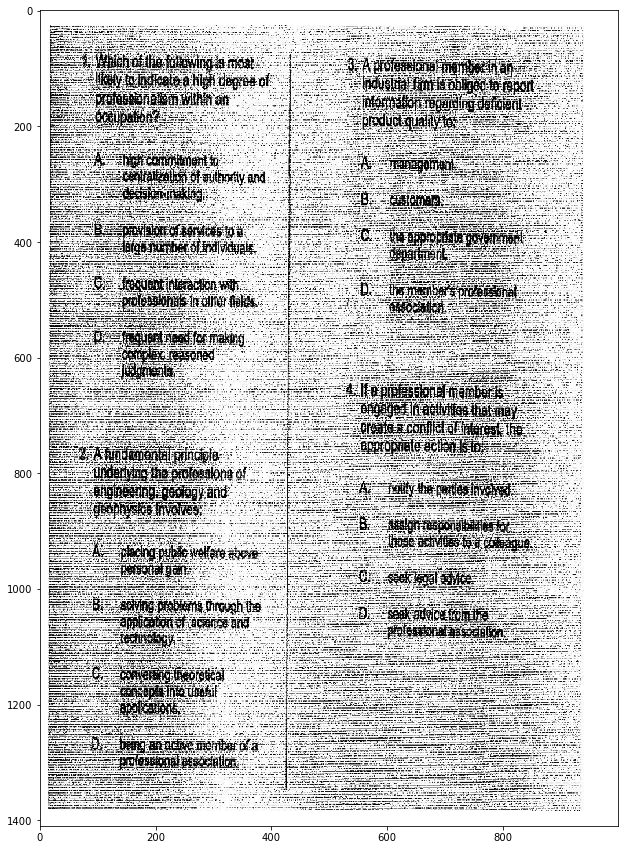

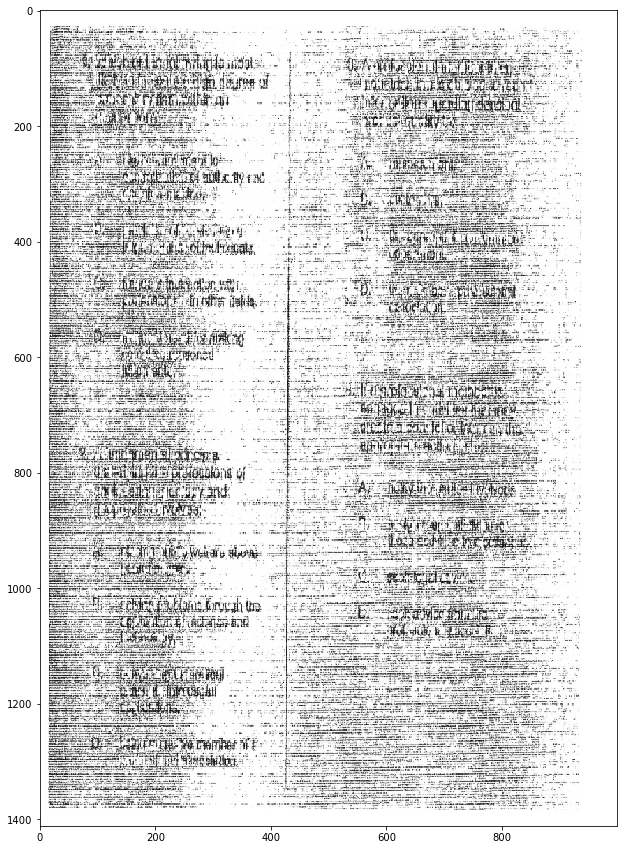

In [34]:
im = Image.open("test/1.jpg").convert('RGB')
im = im.resize((1000, 1410))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, interpolation='nearest')

to_tensor = transforms.ToTensor()
bandw = transforms.Grayscale(num_output_channels=1)
tnsr_im = to_tensor(bandw(im)).unsqueeze(0).to(device)
# print(tnsr_im.shape)
cln_out = model(tnsr_im).detach().cpu().squeeze().unsqueeze(0)
# print(cln_out.mean())
# print(cln_out.shape)
to_pil = transforms.ToPILImage()

im_out = to_pil(cln_out)

# print(np.asarray(im_out).min())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_out, cmap='gray', interpolation='nearest')

im = im.resize((1545, 2398), resample=Image.LANCZOS)
im_out = im_out.resize((1545, 2398), resample=Image.LANCZOS)
im.save('examples/damaged1.png', "PNG")
im_out.save('examples/cleaned1.png', "PNG")

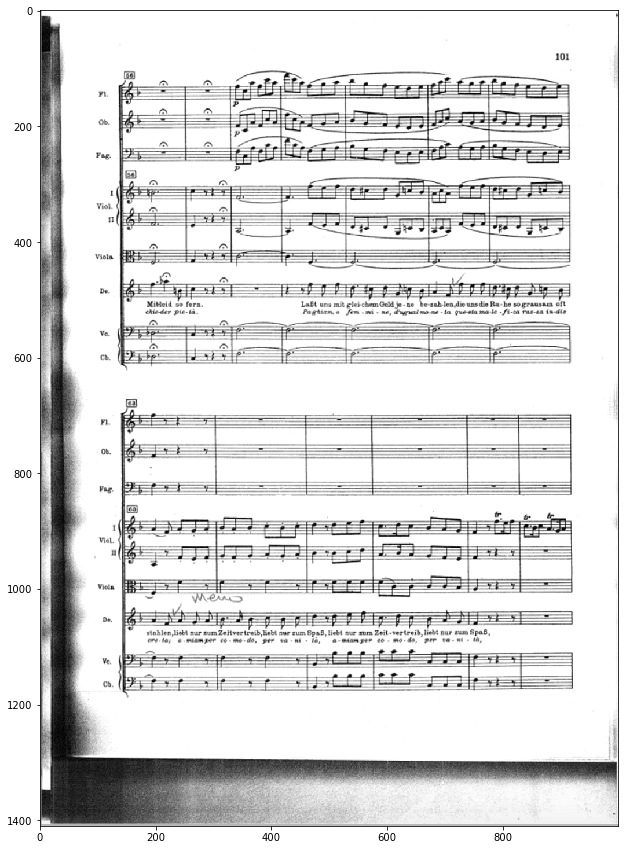

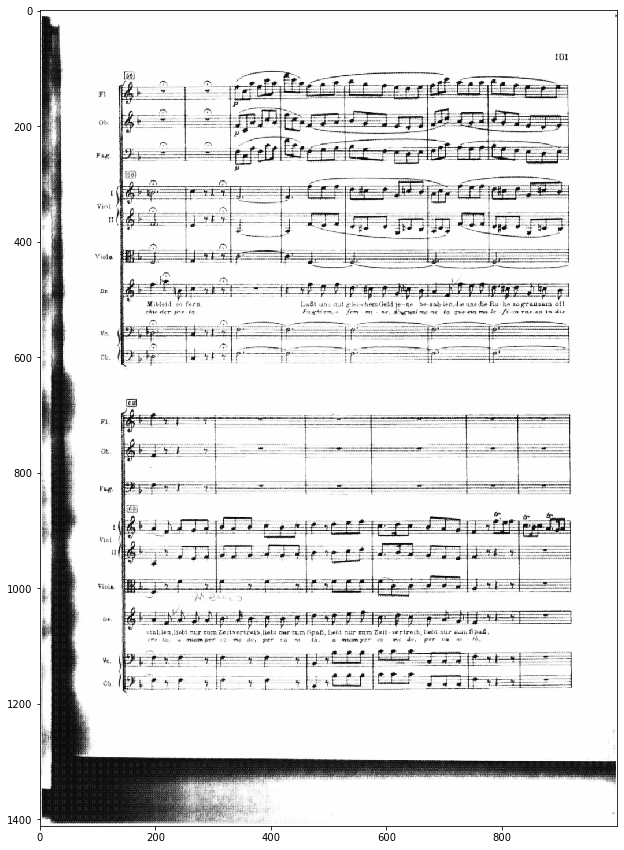

In [35]:
im = Image.open("test/2.png").convert('RGB')
im = im.resize((1000, 1410))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, interpolation='nearest')

to_tensor = transforms.ToTensor()
bandw = transforms.Grayscale(num_output_channels=1)
tnsr_im = to_tensor(bandw(im)).unsqueeze(0).to(device)
# print(tnsr_im.shape)
cln_out = model(tnsr_im).detach().cpu().squeeze().unsqueeze(0)
# print(cln_out.mean())
# print(cln_out.shape)
to_pil = transforms.ToPILImage()

im_out = to_pil(cln_out)

# print(np.asarray(im_out).min())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_out, cmap='gray', interpolation='nearest')

im = im.resize((1545, 2398), resample=Image.LANCZOS)
im_out = im_out.resize((1545, 2398), resample=Image.LANCZOS)
im.save('examples/damaged2.png', "PNG")
im_out.save('examples/cleaned2.png', "PNG")

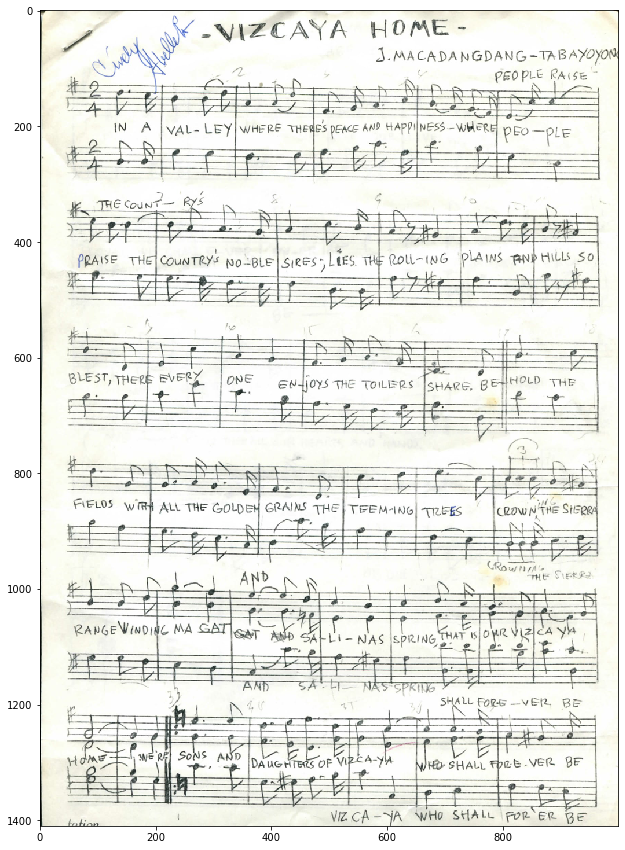

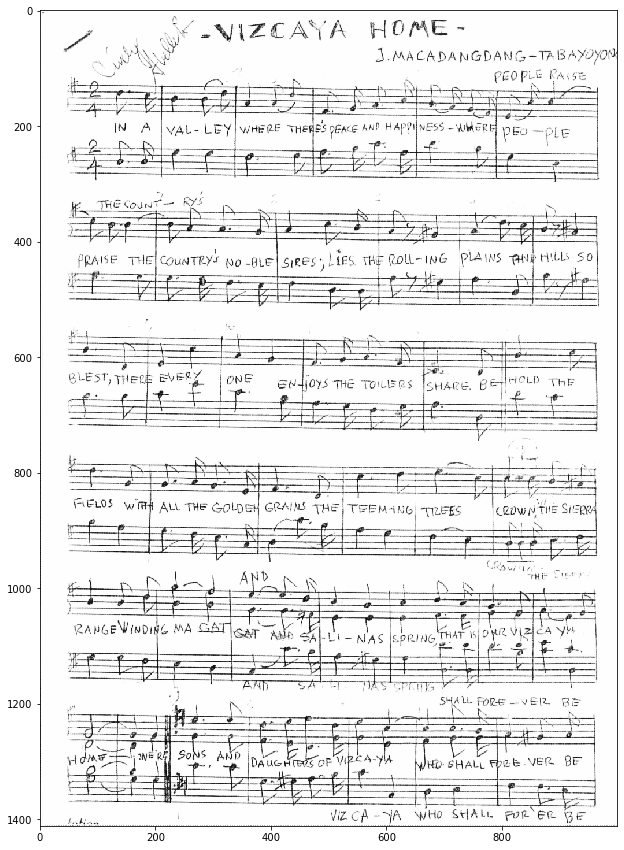

In [36]:
im = Image.open("test/3.jpg").convert('RGB')
im = im.resize((1000, 1410))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, interpolation='nearest')

to_tensor = transforms.ToTensor()
bandw = transforms.Grayscale(num_output_channels=1)
tnsr_im = to_tensor(bandw(im)).unsqueeze(0).to(device)
# print(tnsr_im.shape)
cln_out = model(tnsr_im).detach().cpu().squeeze().unsqueeze(0)
# print(cln_out.mean())
# print(cln_out.shape)
to_pil = transforms.ToPILImage()

im_out = to_pil(cln_out)

# print(np.asarray(im_out).min())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_out, cmap='gray', interpolation='nearest')

im = im.resize((1545, 2398), resample=Image.LANCZOS)
im_out = im_out.resize((1545, 2398), resample=Image.LANCZOS)
im.save('examples/damaged3.png', "PNG")
im_out.save('examples/cleaned3.png', "PNG")

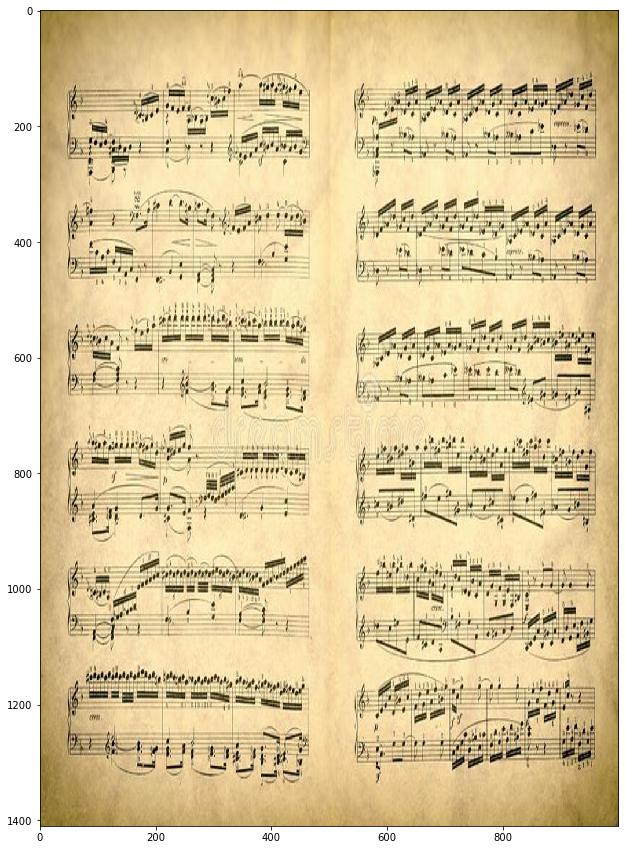

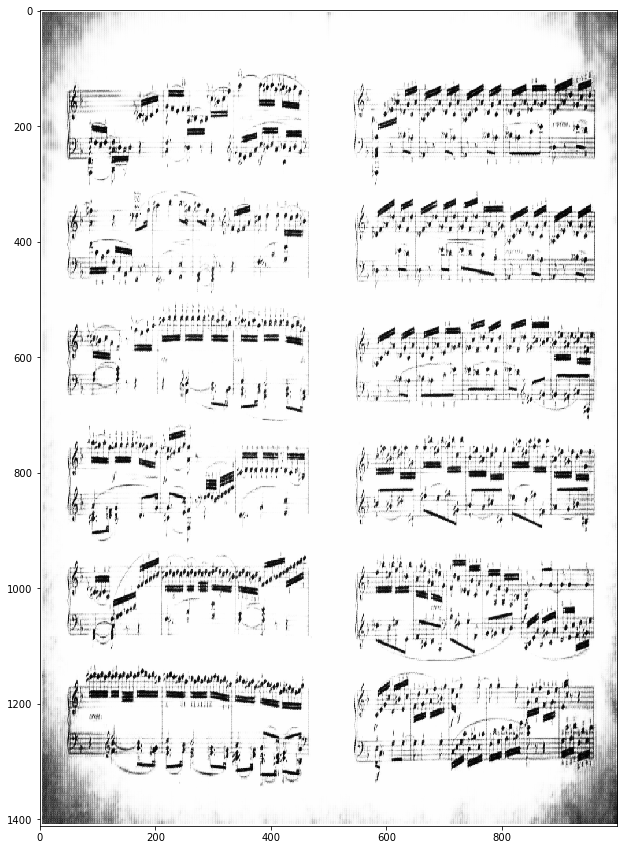

In [37]:
im = Image.open("test/4.jpg").convert('RGB')
im = im.resize((1000, 1410))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, interpolation='nearest')

to_tensor = transforms.ToTensor()
bandw = transforms.Grayscale(num_output_channels=1)
tnsr_im = to_tensor(bandw(im)).unsqueeze(0).to(device)
# print(tnsr_im.shape)
cln_out = model(tnsr_im).detach().cpu().squeeze().unsqueeze(0)
# print(cln_out.mean())
# print(cln_out.shape)
to_pil = transforms.ToPILImage()

im_out = to_pil(cln_out)

# print(np.asarray(im_out).min())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_out, cmap='gray', interpolation='nearest')

im = im.resize((1545, 2398), resample=Image.LANCZOS)
im_out = im_out.resize((1545, 2398), resample=Image.LANCZOS)
im.save('examples/damaged4.png', "PNG")
im_out.save('examples/cleaned4.png', "PNG")

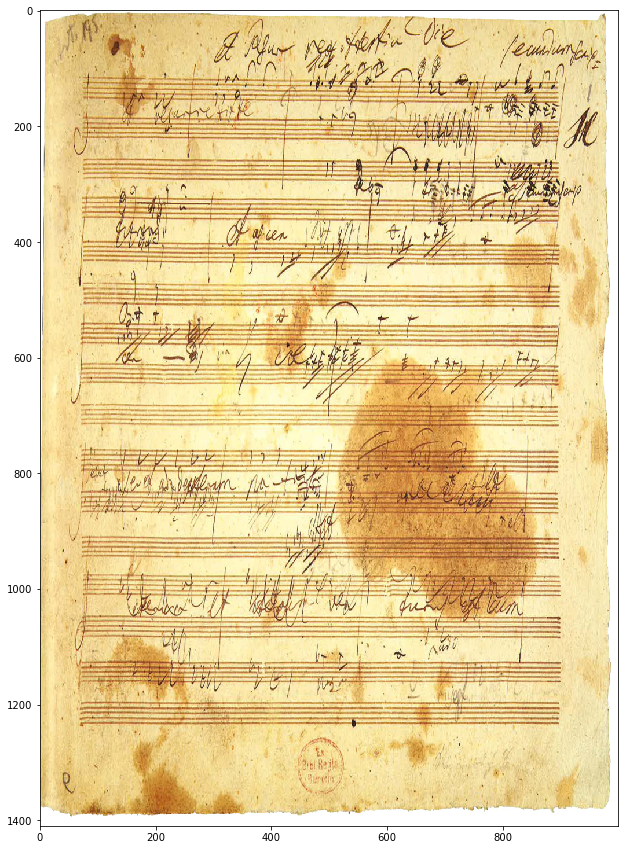

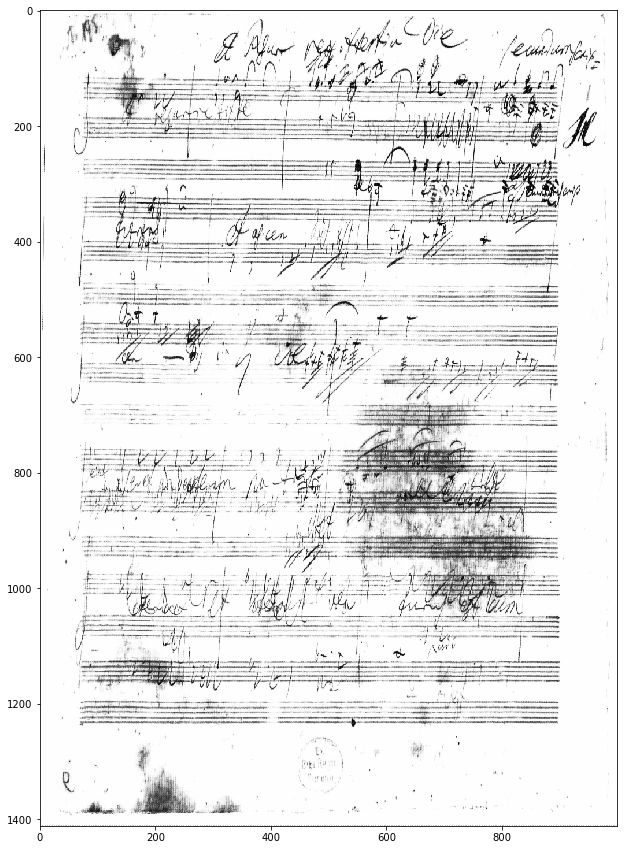

In [38]:
im = Image.open("test/5.jpg").convert('RGB')
im = im.resize((1000, 1410))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, interpolation='nearest')

to_tensor = transforms.ToTensor()
bandw = transforms.Grayscale(num_output_channels=1)
tnsr_im = to_tensor(bandw(im)).unsqueeze(0).to(device)
# print(tnsr_im.shape)
cln_out = model(tnsr_im).detach().cpu().squeeze().unsqueeze(0)
# print(cln_out.mean())
# print(cln_out.shape)
to_pil = transforms.ToPILImage()

im_out = to_pil(cln_out)

# print(np.asarray(im_out).min())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im_out, cmap='gray', interpolation='nearest')

im = im.resize((1545, 2398), resample=Image.LANCZOS)
im_out = im_out.resize((1545, 2398), resample=Image.LANCZOS)
im.save('examples/damaged5.png', "PNG")
im_out.save('examples/cleaned5.png', "PNG")